## Import libraries

In [33]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

# Import forest inventory data

In [36]:
forest_1 = gpd.read_file("Clipped/FAB_Clip.shp")
forest_2 = gpd.read_file("Clipped/ForstBW_Clip.shp")

In [38]:
forest_1.head()

,OBJECTID_1,distrikt,abteilung,revier,bestand,ba1,ba_p_1,ba2,ba_p_2,ba3,...,ba4,ba_p_4,ba5,ba6,ba_p_5,ba_p_6,globalid,SHAPE_Leng,SHAPE_Area,geometry
0,102,9,8,5,d4,Dgl,95,Bu,5,Bi,...,ELä,0,Fi,Ta,0,0,{8270B2EE-9F85-40FF-B384-B106F9A26F4C},455.194691,13689.624493,"POLYGON ((441718.054 5401123.789, 441720.01 54..."
1,99,21,6,4,d2,Dgl,95,BAh,5,Bu,...,EKa,0,Ei,Fi,0,0,{E9958FB6-A492-4F25-BF8B-3F2A34F0E187},372.568392,7934.144329,"POLYGON ((442493.363 5397216.409, 442490.039 5..."
2,227,5,10,3,hW,Lbh,100,None,0,None,...,None,0,None,None,0,0,{027DE92B-388C-4DC4-BAF9-04EC9677C2C0},1022.381385,12529.987465,"POLYGON ((446897.8 5399329.301, 446878.67 5399..."
3,21,5,6,3,b10/2,Lbh,100,Bu,0,Ta,...,None,0,None,None,0,0,{0BA265BD-74FD-4FEF-8EFE-B9F978CCA109},629.994495,19961.880803,"POLYGON ((447177.344 5400771.113, 447172.54 54..."
4,210,1,28,2,r5,Fi,100,Kie,0,Ta,...,Vb,0,None,None,0,0,{F3F726D3-8680-480D-B525-CCF1B6CC397E},230.141169,2118.832750,"POLYGON ((448131.95 5393361.91, 448129.22 5393..."


# Data Cleaning

In [41]:
forest_2 = forest_2.dropna(subset=['LWET_TEXT'])

In [43]:
forest_2.isnull().sum()

OBJECTID_1     0
OBJEKTART      0
NUART         70
WEFLKZ         0
STICHTAG       0
LWET_TEXT      0
SHAPE_Leng     0
SHAPE_Area     0
geometry       0
dtype: int64

## Tree Spicies

In [46]:
# Simplified 5-class mapping (using codes)
species_group_en = {
    "REi": "Oak forest",
    "REr": "Oak forest",
    "Ei": "Oak forest",
    "Bu": "Beech forest",
    "BAh": "Beech forest",
    "Fi": "Coniferous forest",
    "Dgl": "Coniferous forest",
    "Kie": "Coniferous forest",
    "Ndh": "Coniferous forest",
    "Lbh": "Broadleaf forest",
    "Wei": "Broadleaf forest",
    "HPa": "Broadleaf forest",
    "Rob": "Broadleaf forest",
    "sNb": "Mixed forest"
}

In [48]:
forest_1["spicies"] = forest_1["ba1"].map(species_group_en)
forest_2["spicies"] = forest_1["ba1"].map(species_group_en)

In [50]:
# same coordinate system
forest_2 = forest_2.to_crs(forest_1.crs)

# Make sure both GeoDataFrames have the same columns
combined_gdf = pd.concat([forest_1, forest_2], ignore_index=True)

In [52]:
unique_categories = combined_gdf['spicies'].unique()

print(unique_categories)

combined_gdf.isnull().sum()

['Coniferous forest' 'Broadleaf forest' 'Beech forest' 'Oak forest'
 'Mixed forest']


OBJECTID_1      0
distrikt       70
abteilung      70
revier         70
bestand        70
ba1            70
ba_p_1         70
ba2            77
ba_p_2         70
ba3            91
ba_p_3         70
ba4           113
ba_p_4         70
ba5           152
ba6           177
ba_p_5         70
ba_p_6         70
globalid       70
SHAPE_Leng      0
SHAPE_Area      0
geometry        0
spicies         0
OBJEKTART     167
NUART         237
WEFLKZ        167
STICHTAG      167
LWET_TEXT     167
dtype: int64

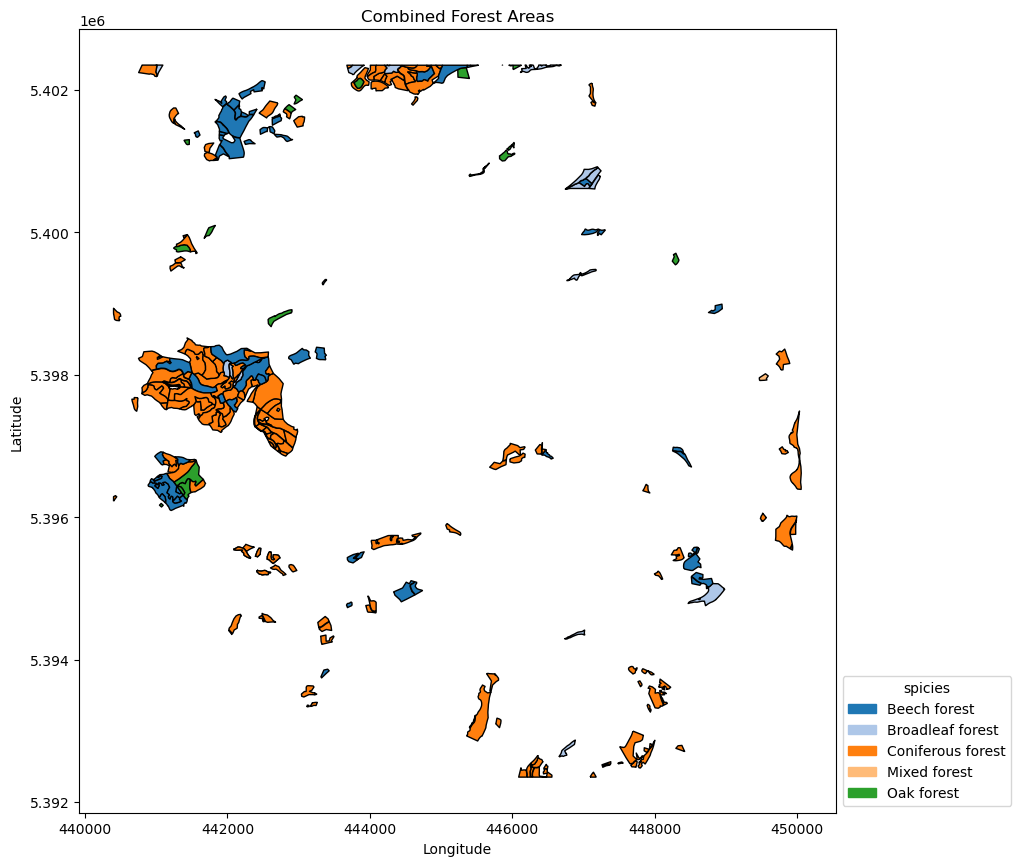

In [54]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Get unique, sorted categories
unique_categories = sorted(combined_gdf['spicies'].unique())

# Assign colors explicitly
colors = plt.cm.tab20.colors
category_colors = {cat: colors[i % len(colors)] for i, cat in enumerate(unique_categories)}

# Create a color list for the GeoDataFrame
combined_gdf['color'] = combined_gdf['spicies'].map(category_colors)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
combined_gdf.plot(
    ax=ax,
    edgecolor='black',
    color=combined_gdf['color']
)

# Create legend
patches = [mpatches.Patch(color=category_colors[cat], label=cat) for cat in unique_categories]
plt.legend(handles=patches, title="spicies", loc='lower left', bbox_to_anchor=(1, 0))

plt.title("Combined Forest Areas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()

## Tree Spicies- Imbalance Classes

In [57]:
# Ensure CRS is WGS84
combined_gdf = combined_gdf.to_crs(epsg=4326)

# Select only required columns
export_gdf = combined_gdf[['OBJECTID_1', 'spicies', 'geometry']]

# Export to KML
export_gdf.to_file("forest_areas.kml", driver='KML')

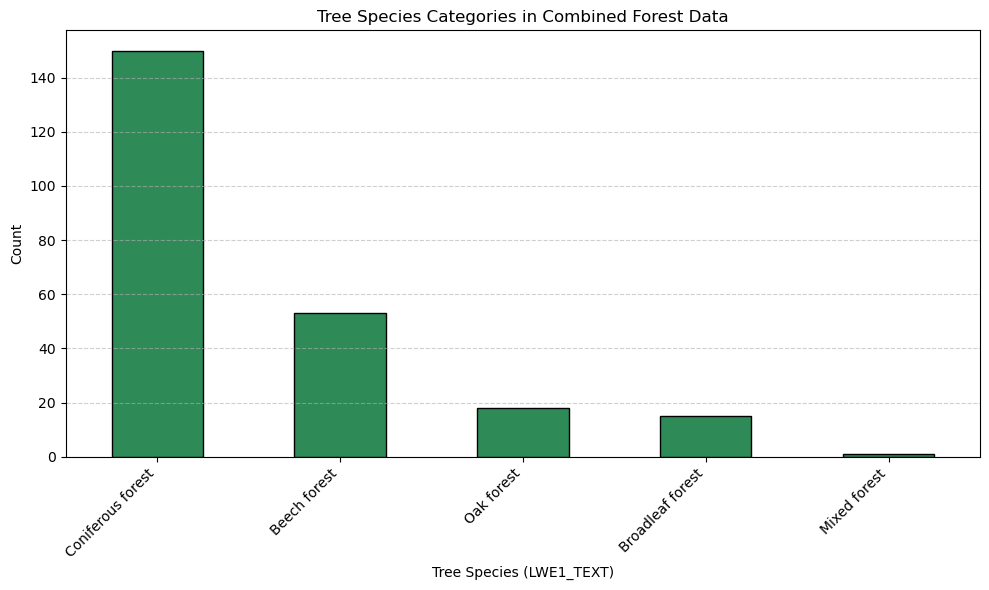

In [59]:
# Count occurrences of each category
category_counts = combined_gdf['spicies'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='seagreen', edgecolor='black')

plt.title("Tree Species Categories in Combined Forest Data")
plt.xlabel("Tree Species (LWE1_TEXT)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [73]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

def generate_random_points_in_polygon(polygon, num_points):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x),
                             np.random.uniform(min_y, max_y))
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Collect all generated points
generated_points = []

# For each polygon in the GeoDataFrame
for idx, row in combined_gdf.iterrows():
    polygon = row.geometry
    spicies = row['spicies']
    points = generate_random_points_in_polygon(polygon, 30)
    for pt in points:
        generated_points.append({'geometry': pt, 'spicies': spicies})

# Create a new GeoDataFrame with the generated points
points_gdf = gpd.GeoDataFrame(generated_points, crs=combined_gdf.crs)

# Optional: visualize or save the generated points
# Export to Shapefile
points_gdf.to_file("generated_points.shp", driver="ESRI Shapefile")

# Random Sampling

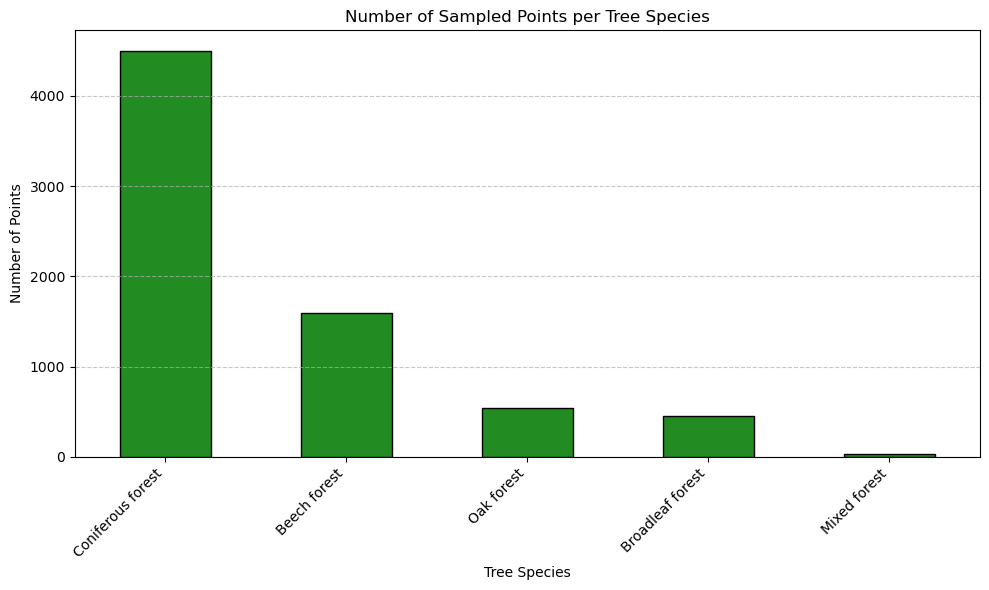

In [75]:
sampled_points_gdf = points_gdf 

# Count points per species
species_counts = sampled_points_gdf['spicies'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar', color='forestgreen', edgecolor='black')

plt.title("Number of Sampled Points per Tree Species")
plt.xlabel("Tree Species")
plt.ylabel("Number of Points")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [78]:
import matplotlib.pyplot as plt

def plot_sampled_points_colored_by_species(polygons_gdf, points_gdf, category_column='spicies'):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot forest polygons
    polygons_gdf.plot(ax=ax, facecolor='lightgrey', edgecolor='black', alpha=0.3)

    # Plot each species with a unique color
    species_list = points_gdf[category_column].unique()
    colors = plt.cm.get_cmap('tab10', len(species_list))

    for idx, species in enumerate(species_list):
        species_points = points_gdf[points_gdf[category_column] == species]
        species_points.plot(ax=ax, color=colors(idx), label=species, markersize=10)

    # Map decorations
    plt.title('Sampled Points per Species over Forest Polygons')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Tree Species')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_9528\2350423032.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(species_list))


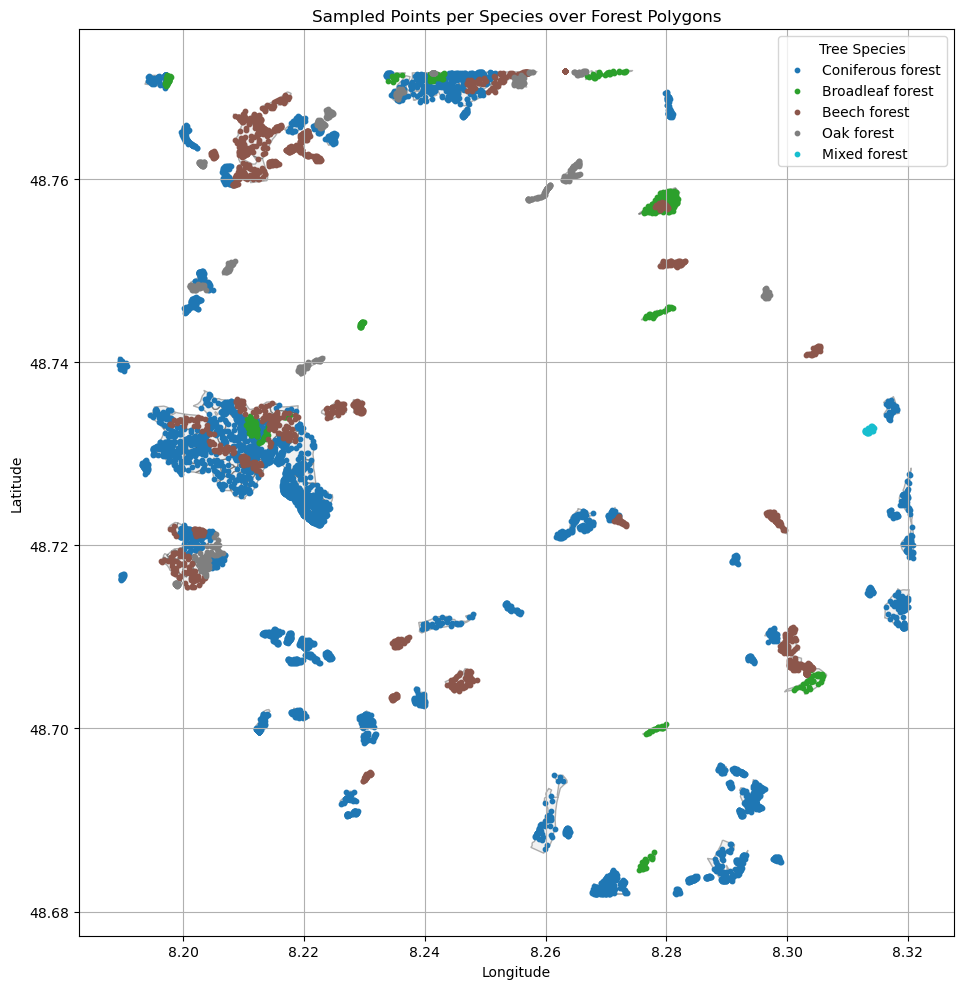

In [80]:
plot_sampled_points_colored_by_species(combined_gdf, sampled_points_gdf, category_column='spicies')

## Export to shapefile and KML

In [83]:
# Ensure your geometry is in WGS84 (EPSG:4326) for KML export
sampled_points_gdf_wgs84 = sampled_points_gdf.to_crs(epsg=4326)

# Export to KML
sampled_points_gdf_wgs84.to_file("sampled_points_new.kml", driver='KML')

# Shapefile export can use original CRS or convert to EPSG:4326 as needed
sampled_points_gdf.to_file("sampled_points_new.shp", driver='ESRI Shapefile')